# The Gaussian Model
## A back-of-the-envelope sketch of COVID-19 infections.
### Based on the methodology [in this post](https://towardsdatascience.com/the-gaussian-model-4a94a2b3ff1b)

In [80]:
# Import libraries
import scipy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#import os
#os.getcwd()

In [3]:
data = pd.read_excel('https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-28.xlsx')
data.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
0,2020-03-28,28,3,2020,16,1,Afghanistan,AF,AFG,37172386.0
1,2020-03-27,27,3,2020,0,0,Afghanistan,AF,AFG,37172386.0
2,2020-03-26,26,3,2020,33,0,Afghanistan,AF,AFG,37172386.0
3,2020-03-25,25,3,2020,2,0,Afghanistan,AF,AFG,37172386.0
4,2020-03-24,24,3,2020,6,1,Afghanistan,AF,AFG,37172386.0


In [ ]:
country='India'
country_data = data[data['countriesAndTerritories'] == country]
country_data['dateRep']=pd.to_datetime(country_data['dateRep'],'%Y-%m-%d')
country_data.sort_values(by='dateRep',ascending='True',inplace=True)
country_data.reset_index(inplace=True)
country_data.head()

In [5]:
max_data = country_data.sort_values('cases',ascending=False)
max_data.head()

,index,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018
87,3028,2020-03-28,28,3,2020,149,2,India,IN,IND,1.352617e+09
82,3033,2020-03-23,23,3,2020,119,3,India,IN,IND,1.352617e+09
81,3034,2020-03-22,22,3,2020,89,0,India,IN,IND,1.352617e+09
85,3030,2020-03-26,26,3,2020,87,4,India,IN,IND,1.352617e+09
86,3029,2020-03-27,27,3,2020,75,4,India,IN,IND,1.352617e+09


Text(0.5, 1.0, 'India - Current')

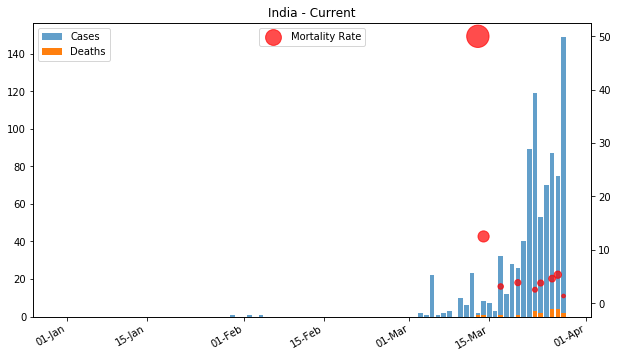

In [128]:
country_cases = country_data['cases']
country_deaths = country_data['deaths']
country_mortality_rate = country_data['deaths']*100/country_data['cases']
country_mortality_rate.replace(np.nan,0,inplace=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(country_data['dateRep'],country_cases,label='Cases',alpha=0.7)
ax.bar(country_data['dateRep'],country_deaths,label='Deaths')
ax2 = ax.twinx()
ax2.scatter(country_data['dateRep'],country_mortality_rate,s=country_mortality_rate*10,
            c='r',alpha=0.7,label='Mortality Rate')
myFmt = mdates.DateFormatter('%d-%b')
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.legend()
ax2.legend(loc='upper center')
ax.set_title('India - Current')

In [6]:
x = range(len(country_data))
y = country_data['cases'].values
est_mu = max_data.index[0]
est_N = y.max()
est_sigma = len(country_data)/10
est_N, est_mu,len(country_data)/10

(149, 87, 8.8)

In [17]:
from astropy import modeling

init_m = modeling.models.Gaussian1D(amplitude=est_N, mean=est_mu, stddev=est_sigma)
fit_m = modeling.fitting.LevMarLSQFitter()
m = fit_m(init_m, x, y)
y_fa = m(x)
m

from scipy.optimize import curve_fit

def gauss(x,N,mu,sigma):
    return N*np.exp(-(x-mu)**2/(2*sigma**2))

mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

popt,pcov = curve_fit(gauss,x,y,p0=[est_N,mean,sigma],maxfev=10000)
y_fs = gauss(x,*popt)

from lmfit import Model
gmodel = Model(gauss)
y_flm = gmodel.fit(y, x=x, N=est_N, mu=mean, sigma=sigma)

print('Results from LMFIT: \n ',result.fit_report())



Results from LMFIT: 
  [[Model]]
    Model(gauss)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 88
    # variables        = 3
    chi-square         = 8465.45186
    reduced chi-square = 99.5935512
    Akaike info crit   = 407.844244
    Bayesian info crit = 415.276254
[[Variables]]
    N:      213.253041 +/- 167.209919 (78.41%) (init = 149)
    mu:     98.1921810 +/- 10.9267081 (11.13%) (init = 81.53952)
    sigma:  10.4538361 +/- 3.51167259 (33.59%) (init = 5.961973)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, mu)     =  0.992
    C(mu, sigma) =  0.990
    C(N, sigma)  =  0.967


In [56]:
print('Your best fit parameters with uncertainity are (from lmfit, \n')
y_flm.params

Your best fit parameters with uncertainity are (from lmfit, 



name,value,standard error,relative error,initial value,min,max,vary
N,213.253041,167.209919,(78.41%),149,-inf,inf,True
mu,98.1921810,10.9267081,(11.13%),81.53951890034364,-inf,inf,True
sigma,10.4538361,3.51167259,(33.59%),5.961972524084292,-inf,inf,True


Your initial parameters were (astropy) 
 N = 149 	 mu = 87 	 sigma = 8.8
Your initial parameters were (scipy) 
 N = 149 	 mu = 82 	 sigma = 6

 Your fitted parameters were (astropy) 
 N = 213 	 mu = 98 	 sigma = 10

 Your fitted parameters were (scipy) 
 N = 213 	 mu = 98 	 sigma = 10

Total cases till today,  873
Model Cases (model total area), 5589 
Accuracy of the Gaussian model, 640% 
Area fraction - India is about 16% into COVID-19


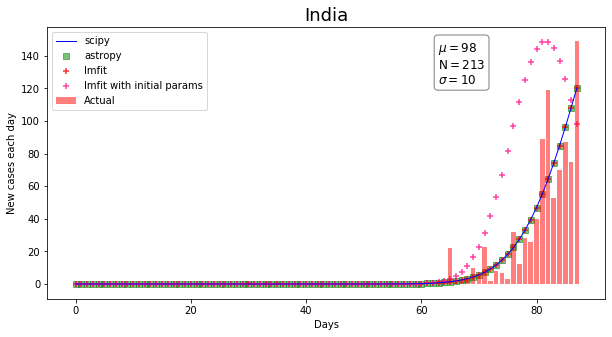

In [57]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x,y_fs,'b',lw=1,label='scipy')
ax.scatter(x,y_fa,c='g',marker='s',label='astropy',alpha=0.5)
ax.scatter(x,y_flm.best_fit,c='r',marker='+',label='lmfit',alpha=0.8)
ax.scatter(x,y_flm.init_fit,c='deeppink',marker='+',label='lmfit with initial params',alpha=0.8)
ax.bar(x,y,alpha=0.5,color='red',label='Actual')
textstr = '\n'.join((
    r'$\mu=%.0f$' % (m.mean[0], ),
    r'$\mathrm{N}=%.0f$' % (m.amplitude[0], ),
    r'$\sigma=%.0f$' % (m.stddev[0], )))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.7, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.title(country,fontsize=18)
plt.xlabel('Days')
plt.ylabel('New cases each day')
plt.legend(loc='upper left')


print('Your initial parameters were (astropy) \n N = {} \t mu = {} \t sigma = {}'.format(est_N,est_mu,est_sigma))
print('Your initial parameters were (scipy) \n N = {} \t mu = {:.0f} \t sigma = {:.0f}'.format(est_N,mean,sigma))
print('\n Your fitted parameters were (astropy) \n N = {:.0f} \t mu = {:.0f} \t sigma = {:.0f}'.format(m.amplitude[0],m.mean[0],m.stddev[0]))
print('\n Your fitted parameters were (scipy) \n N = {:.0f} \t mu = {:.0f} \t sigma = {:.0f}'.format(*popt))
total_cases = country_data['cases'].sum()
print('\nTotal cases till today, ',total_cases)
model_cases = m.amplitude[0]*m.stddev[0]*np.sqrt(2*np.pi)
print("Model Cases (model total area), {:.0f} " .format(model_cases))
print('Accuracy of the Gaussian model, {:.0f}% '.format(model_cases*100/total_cases))
area_frac = total_cases/model_cases
print('Area fraction - {} is about {:.0f}% into COVID-19'.format(country,area_frac*100))

(<Figure size 432x432 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

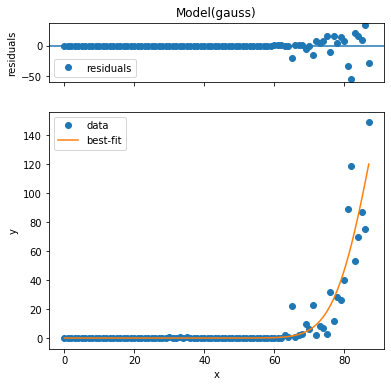

In [59]:
y_flm.plot()